# Using word embedding for movies recommendation

Other implementation of word embedding neural network for movies recommendation.

Focusing here on movies **GENRES**

# 1) Importations and functions

In [347]:
%pylab inline
import pandas as pd
import os
import seaborn as sns
import random
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model, model_from_json
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from sklearn import preprocessing, decomposition, manifold, cluster
import pickle
from matplotlib.patches import Patch
import matplotlib as mpl
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

Populating the interactive namespace from numpy and matplotlib


/home/noel/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def dynamic_std_print(string_to_print):
    """
    Printing string on standard output and refreshing output line
    """
    sys.stdout.write('\r')
    sys.stdout.write(string_to_print)
    sys.stdout.flush()

In [3]:
def switch_term(terms_list, old_term, new_term):
    for i in range(len(terms_list)):
        terms_list[i] = terms_list[i].replace(old_term, new_term)
    return terms_list

In [5]:
def isgenre(row, genre):
    isgenre = False
    if genre in row.genres_list:
        isgenre = True
    elif genre in row.kw_list:
        isgenre = True
    if isgenre:
        out = 1
    else:
        out = 0
    return out

In [94]:
def generate_batch(pairs, n_positive=50, negative_ratio=1.0, classification=False):
    """
    Generate batches of samples for training
    """
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # Get pairs set
    pairs_set = set(pairs)

    # Adjust label based on task
    if classification:
        neg_label = 0
    else:
        neg_label = -1
    
    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, (movie_id, genre_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (movie_id, genre_id, 1)

        # Increment idx by 1
        idx += 1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            random_movie = random.randrange(genres_kw_df.shape[0])
            random_genre = random.randrange(len(unique_genres))
            
            # Check to make sure this is not a positive example
            if (random_movie, random_genre) not in pairs_set:
                
                # Add to batch and increment index
                batch[idx, :] = (random_movie, random_genre, neg_label)
                idx += 1
                
        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'movie': batch[:, 0], 'genre': batch[:, 1]}, batch[:, 2]

In [56]:
def movies_embedding_model(movies_shape, genres_shape, embedding_size=50, classification=False):
    """
    Model to embed books and wikilinks using the functional API.
    Trained to discern if a movie is of a particular genre
    """
    
    # Both inputs are 1-dimensional
    movie = Input(name = 'movie', shape = [1])
    genre = Input(name = 'genre', shape = [1])
    
    # Embedding the movies (shape will be (None, 1, 50))
    movie_embedding = Embedding(name = 'movie_embedding',
                                 input_dim = movies_shape,
                                 output_dim = embedding_size)(movie)
    
    
    # Embedding the keywords (shape will be (None, 1, 50))
    genre_embedding = Embedding(name = 'genre_embedding',
                            input_dim = genres_shape,
                            output_dim = embedding_size)(genre)
    
    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([movie_embedding, genre_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)
    
    # If classifcation, add extra layer and loss function is binary cross entropy
    if classification:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [movie, genre], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Otherwise loss function is mean squared error
    else:
        model = Model(inputs = [movie, genre], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

In [57]:
def train_embedding(pairs, shape_movies, shape_genre, n_positive=1000, emb_size=50, verb=1):
    """
    Train neural network
    """
    # Instantiate model and show parameters
    model = movies_embedding_model(shape_movies, shape_genre, emb_size)
 
    # Generate batch
    gen = generate_batch(pairs, n_positive, negative_ratio=2, classification=True)

    # Train
    h = model.fit_generator(gen, epochs=10, 
                            steps_per_epoch=len(pairs) // n_positive,
                            verbose=verb)
    return h, model

In [9]:
def extract_embedding(layer, selection_id):
    """
    Output trained weights from embedding layer and use it to get closest recommendations
    """
    # Extract embeddings
    weights = layer.get_weights()[0]
    # Normalize weights
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    # Calculate dot product between movie and all others
    dists = np.dot(weights, weights[selection_id])
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    # Take the last n sorted distances
    closest = sorted_dists[-11:]
    closest = [x for x in reversed(closest)]
    return closest, weights

In [10]:
def recom_genres(ref_genres, recommendation_df):
    """
    bar plot of genre in recommendations
    """
    list_genres = ref_genres.split(',')
    genres_recom = pd.Series(",".join(recommendation_df.genres.values.tolist()).split(",")).value_counts()
    # Gather all genres (ref and recom)
    all_genres = set(list_genres + genres_recom.index.values.tolist())
    # Get other genres
    other_genres = all_genres - set(list_genres)
    # Create serie for bar plot
    genres_bar_df = pd.Series(0, index=[list_genres + list(other_genres)])
    # Fill bar plot
    for genre in genres_recom.index:
        genres_bar_df.loc[genre] = genres_recom.loc[genre]
    return genres_bar_df

In [11]:
def recom_kw(ref_kw, recommendation_df):
    """
    Histogram of keywords in recommendations
    """
    list_kw = ref_kw.split(',')
    kw_recom = pd.Series(",".join(recommendation_df.keywords.values.tolist()).split(",")).value_counts()
    # Gather all kw (ref and recom)
    all_kw = set(list_kw + kw_recom.index.values.tolist())
    # Get other kw
    other_kw = all_kw - set(list_kw)
    # Create serie for histogram
    kw_histo_df = pd.Series(0, index=[list_kw + list(other_kw)])
    # Fill histogram
    for kw in kw_recom.index:
        kw_histo_df.loc[kw] = kw_recom.loc[kw]
    return kw_histo_df

In [12]:
# get a color map
my_cmap = cm.get_cmap('jet')
# get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=0, vmax=12)
# some boring fake data
myblue = 3
myorange = 9
# get a color map with two different colors
cmap_2c = cm.get_cmap('bwr')
# get normalize function (takes data in range [vmin, vmax] -> [0, 1])
norm_2c = Normalize(vmin=0, vmax=1)

In [221]:
def find_movie(string, movies_df):
    """
    Snippet of code to find movie based on its title. Find movie based on its title
    """
    return movies_df[movies_df['title'].str.lower().str.contains(string)]

In [14]:
def recommender_behaviour_study(input_df, main_df):
    """
    Take a dataframe as input and output two plots and mean accuracy for genres and keywords for 10 predictions
    """
    genres_acc = []
    kw_acc = []
    for i in range(0, len(input_df)):
        dynamic_std_print('Movie %i / %i' % (i+1, len(input_df)))
        # Movie id
        temp_movie_id = input_df.iloc[i].name
        # Extract weights
        recom_movie, movies_weights = extract_embedding(layer, temp_movie_id)
        # Get recommendations (closest movies)
        recom_df = main_df.loc[recom_movie[1:], ['title', 'genres', 'keywords']]
        # Get recommendations genres
        genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
        # Count genres of selected movie
        n_genres = len(main_df.loc[temp_movie_id, :].genres_list)
        # Process recommendation genres
        genres_recommendation = recom_genres(main_df.loc[temp_movie_id, :].genres, recom_df)
        # Compute genres accuracy for recommendations
        genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
        genres_acc.append(genres_accuracy)
        # Count kw of selected movie
        n_kw = len(main_df.loc[temp_movie_id, :].kw_list)
        # Process recommendation keywords
        keywords_recommendation = recom_kw(main_df.loc[temp_movie_id, :].keywords, recom_df)
        # Compute kw accuracy for recommendations
        kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
        kw_acc.append(kw_accuracy)
        
    # Genres plot
    fig, ax = plt.subplots()
    ax = sns.distplot(genres_acc, bins=100, kde=False)
    ax.set_xlabel("Recommendations genres accuracy", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.set_title("Genres accuracy", fontsize=12)
    # Keywords plot
    fig, ax = plt.subplots()
    ax = sns.distplot(kw_acc, bins=100, kde=False)
    ax.set_xlabel("Recommendations keywords accuracy", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.set_title("Keywords accuracy", fontsize=12)
    print('\n')
    print('Genres accuracy : {:.2f}'.format(mean(genres_acc)))
    print('Keywords accuracy : {:.2f}'.format(mean(kw_acc)))
    
    return mean(genres_acc), mean(kw_acc)

In [15]:
def recom_genres_study(ref, recom):
    # get a color map
    my_cmap = cm.get_cmap('jet')
    # get normalize function (takes data in range [vmin, vmax] -> [0, 1])
    my_norm = Normalize(vmin=0, vmax=12)
    # some boring fake data
    myblue = 3
    myorange = 9
    # Count genres of selected movie
    n_genres = len(ref.genres_list)
    # Process recommendation genres
    genres_recommendation = recom_genres(ref.genres, recom)
    # Define vector for colors
    my_data = [myblue]*n_genres + (genres_recommendation.shape[0] - n_genres)*[myorange]
    # Plot bar plot
    genres_recommendation.plot.barh(color=my_cmap(my_norm(my_data)), fontsize=12)
    # Get axes for graph tuning
    ax = plt.gca()
    # Set legend elements
    legend_elements = [Patch(facecolor=my_cmap(my_norm([3]))[0], label='ref genres'),
                       Patch(facecolor=my_cmap(my_norm([9]))[0], label='other genres')]
    # Create handmade legend
    ax.legend(handles=legend_elements)
    # Set axis labels and title
    ax.set_xlabel("Frequency in recommendations", fontsize=12)
    ax.set_ylabel("Genres", fontsize=12)
    ax.set_title("Genres in 5 first recommendations", fontsize=12);
    # Compute genres accuracy for recommendations
    genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
    print('Genres accuracy : {:.2f}'.format(genres_accuracy))

In [16]:
def recom_kw_study(ref, recom):
    # get a color map
    my_cmap = cm.get_cmap('jet')
    # get normalize function (takes data in range [vmin, vmax] -> [0, 1])
    my_norm = Normalize(vmin=0, vmax=12)
    # some boring fake data
    myblue = 3
    myorange = 9
    # Count kw of selected movie
    n_kw = len(ref.kw_list)
    # Process recomendation keywords
    keywords_recommendation = recom_kw(ref.keywords, recom)
    # Define vector for colors
    my_data = [myblue]*n_kw + (keywords_recommendation.shape[0] - n_kw)*[myorange]
    # Plot
    # First plot : movie's keywords histogram
    fig, ax = plt.subplots()
    ax = keywords_recommendation.plot.hist(color=my_cmap(my_norm(my_data)), fontsize=12, bins=len(keywords_recommendation.unique()))
    # Set axis labels and title
    ax.set_xlabel("Frequency in recommendations", fontsize=12)
    ax.set_ylabel("Counts", fontsize=12)
    ax.set_title("Keywords in 10 first recommendations", fontsize=12)
    # pyplot.locator_params(axis='x', nbins=3)
    # Second plot : movie's keywords frequency
    fig, ax = plt.subplots()
    # Movie's keywords for barplot
    movie_kw = keywords_recommendation.loc[ref.kw_list]
    ax = movie_kw.plot.barh(fontsize=12)
    # Set axis labels and title
    ax.set_xlabel("Keywords frequency in recommendation", fontsize=12)
    ax.set_ylabel("Movie's keywords", fontsize=12)
    ax.set_title("Movie's keywords in 10 first recommendations", fontsize=12);
    # Compute kw accuracy for recommendations
    kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
    print('Keywords accuracy : {:.2f}'.format(kw_accuracy))

# 2) Data loading

In [17]:
# Getting current path
path = os.getcwd()
file = '/data/movie_metadata_large.csv'

# Verifying data presence
try :
    data_raw = pd.read_csv(path + file, sep=',')
except FileNotFoundError :
    print("Please check if the file %s is in the 'data' folder at the current location" % file)

# 3) Data first observation

In [18]:
data_raw.shape

(53705, 4)

Not to big of a dataset, what's in it ?

In [19]:
data_raw.head()

,title,cast,genres,keywords
0,Batman & Robin,"George Clooney,Chris O'Donnell,Arnold Schwarze...","Science Fiction,Action,Fantasy,Comedy","double life,dc comics,dual identity,crime figh..."
1,About the Looking for and the Finding of Love,"Moritz Bleibtreu,Alexandra Maria Lara,Uwe Ochs...","Comedy,Drama","berlin germany,suicide,lovesickness,greece,com..."
2,The Life Aquatic with Steve Zissou,"Bill Murray,Anjelica Huston,Cate Blanchett,Wil...","Adventure,Comedy,Drama","parent child relationship,red cap,rivalry,dysf..."
3,8½,"Marcello Mastroianni,Claudia Cardinale,Anouk A...","Fantasy,Drama","individual,scapegoat,adultery,screenplay,cinec..."
4,The Pianist,"Adrien Brody,Thomas Kretschmann,Frank Finlay,M...","Drama,War","resistance,holocaust,hunger,world war ii,priso..."


Obvious duplicates ?

In [20]:
data_raw[data_raw.duplicated()].shape

(12, 4)

Drop obvious duplicates if any

In [21]:
data_raw = data_raw.drop_duplicates(keep='first')
data_raw.shape

(53693, 4)

Movies duplicates ?

In [22]:
dup = data_raw[data_raw.duplicated(subset=["title"])]
n_dup = dup.shape[0]
print("%i duplicates sharing movie title" % n_dup)
print(dup.title.head(10))

2825 duplicates sharing movie title
49                       Shaft
303                    The Fog
311          Annaluise & Anton
318                   The Omen
383         Planet of the Apes
424    The Thomas Crown Affair
434           Dawn of the Dead
524         The Miracle Worker
640    Blood: The Last Vampire
753                      Crash
Name: title, dtype: object


Duplicates are most likely remakes

In [23]:
data_raw[data_raw.title == "The Thomas Crown Affair"]

,title,cast,genres,keywords
423,The Thomas Crown Affair,"Steve McQueen,Faye Dunaway,Paul Burke,Jack Wes...","Romance,Crime,Thriller,Drama","in love with enemy,hold-up robbery,boredom,ins..."
424,The Thomas Crown Affair,"Pierce Brosnan,Rene Russo,Denis Leary,Ben Gazz...","Drama,Crime,Romance","martinique,claude monet,famous painting,glider..."


# 4) Missing values

In [24]:
data_raw.isna().sum()

title           0
cast         5271
genres       5496
keywords    21723
dtype: int64

Remove rows with missing values

In [25]:
data_raw = data_raw.dropna(subset=['genres'])
data_raw.shape

(48197, 4)

In [26]:
data_raw.isna().sum()

title           0
cast         3091
genres          0
keywords    17426
dtype: int64

# 5) Feature Engineering

In [27]:
data_raw.head(1)

,title,cast,genres,keywords
0,Batman & Robin,"George Clooney,Chris O'Donnell,Arnold Schwarze...","Science Fiction,Action,Fantasy,Comedy","double life,dc comics,dual identity,crime figh..."


Pass genres to lowercase

In [28]:
data_raw.loc[:, 'genres'] = data_raw.genres.apply(lambda x: x.lower())

In [29]:
data_raw.head(1)

,title,cast,genres,keywords
0,Batman & Robin,"George Clooney,Chris O'Donnell,Arnold Schwarze...","science fiction,action,fantasy,comedy","double life,dc comics,dual identity,crime figh..."


In [30]:
# Filter out stop words
stop_words = set(stopwords.words('english'))

In [31]:
# Modifying the genres as well
data_raw.loc[:, 'genres'] = data_raw.loc[:, 'genres'].apply(lambda x: x.replace('science fiction', 'scifi'))

In [35]:
# Get splitted genres in a serie
s = data_raw.genres.str.lower().str.split(",").values.tolist()
# Get unique genres
unique_genres_list = [genres_out for genres_in in s for genres_out in genres_in]
set_genres = set(unique_genres_list)
unique_genres = list(set_genres)
print("%i genres in the dataset" % len(unique_genres))
genres_index = {genre: idx for idx, genre in enumerate(unique_genres)}

19 genres in the dataset


Create new dataframe

In [121]:
genres_kw_df = data_raw.loc[:, ['title', 'genres', 'keywords']]
genres_kw_df = genres_kw_df.reset_index(drop=True)
genres_kw_df.head(1)

,title,genres,keywords
0,Batman & Robin,"scifi,action,fantasy,comedy","double life,dc comics,dual identity,crime figh..."


In [122]:
# Take strings and output list of tokens in lower case
genres_kw_df.loc[:, 'genres_list'] = genres_kw_df.genres.apply(lambda x: x.lower().split(","))
genres_kw_df.keywords = genres_kw_df.keywords.fillna('nan')
genres_kw_df.loc[:, 'kw_list'] = genres_kw_df.keywords.apply(lambda x: x.lower().split(",") if x != 'nan' else [])

In [40]:
# Beware of sci-fi
genres_kw_df.loc[:, 'genres_list'] = genres_kw_df.genres_list.apply(switch_term, args=('sci-fi', ('scifi')))
genres_kw_df.loc[:, 'kw_list'] = genres_kw_df.kw_list.apply(switch_term, args=('sci fi', ('scifi')))

# 6) Supervised learning issue : is a genre in a specific movie's genres ?

In [42]:
genres_kw_df.head(1)

,title,genres,keywords,genres_list
0,Batman & Robin,"scifi,action,fantasy,comedy","double life,dc comics,dual identity,crime figh...","[scifi, action, fantasy, comedy]"


### Building pairs for supervised training : is a specific genre in the movies genres ?

In [43]:
try:
    pairs = pickle.load(open(path + '/data/pairs_genres.pkl', 'rb'))
except FileNotFoundError:
    pairs = []
    # Iterate through each movie
    for i in range(0, genres_kw_df.shape[0]):
        dynamic_std_print('Movie %i / %i' % (i, genres_kw_df.shape[0]))
        # Iterate through the genres of the movies
        pairs.extend((i, genres_index[genre]) for genre in genres_kw_df.iloc[i, :].genres_list if genre in unique_genres)
    pickle.dump(pairs, open(path + '/data/pairs_genres.pkl', 'wb'))

Movie 48196 / 48197Movie 46810 / 48197

In [46]:
print('We have less than %i positives examples' % (ceil(len(pairs) / 10000) * 10000))

We have less than 100000 positives examples


Test batch-generating function

In [93]:
next(generate_batch(pairs, n_positive=2, negative_ratio=2))

({'movie': array([37266., 11170., 44203., 24635.,   855., 12821.]),
  'kw': array([ 6.,  6.,  0., 14.,  0.,  9.])},
 array([-1., -1., -1., -1.,  1.,  1.]))

Save input dataframe for easy loading and usage in hard code

In [349]:
# pickle.dump(genres_kw_df, open('data/recom_genres_df.pkl', 'wb'))

# 7) Neural Network Model

Implement the neural network with two embedding layers :
- one for the movies titles
- one for the genres

In [95]:
n_positive = 1000
try:
    # load json and create model
    json_file = open(path + '/data/model_genres.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    emb_model = model_from_json(loaded_model_json)
    # load weights into new model
    emb_model.load_weights(path + "/data/model_genres.h5")
    print("Loaded model from disk")
except FileNotFoundError:
    history, emb_model = train_embedding(pairs, genres_kw_df.shape[0], len(unique_genres), n_positive, emb_size=100)
    # serialize model to JSON
    model_json = emb_model.to_json()
    with open(path + "/data/model_genres.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    emb_model.save_weights(path + "/data/model_genres.h5")
    print("Saved model to disk")

Epoch 1/10
96/96 [==============================] - 20s 204ms/step - loss: 0.3074
Epoch 2/10
96/96 [==============================] - 19s 194ms/step - loss: 0.2022
Epoch 3/10
96/96 [==============================] - 19s 203ms/step - loss: 0.1417
Epoch 4/10
96/96 [==============================] - 19s 193ms/step - loss: 0.1054
Epoch 5/10
96/96 [==============================] - 18s 192ms/step - loss: 0.0890
Epoch 6/10
96/96 [==============================] - 19s 195ms/step - loss: 0.0681
Epoch 7/10
96/96 [==============================] - 19s 193ms/step - loss: 0.0662
Epoch 8/10
96/96 [==============================] - 18s 187ms/step - loss: 0.0671
Epoch 9/10
96/96 [==============================] - 18s 188ms/step - loss: 0.0523
Epoch 10/10
96/96 [==============================] - 18s 187ms/step - loss: 0.0544


As we see the model's loss to decrease as the epochs run, we may have hope that the model is learning somethin.

Let's point out that the supervised learning is what we are looking for here, not the classification outcome. The learning itself allows the model to actually learn and modify the embeddings layers weights, which are the coordinates of our words (titles or keywords) in their own vectorial 50 (or 100) - dimensional space.

In [96]:
# Select any movie for testing
movie_id = 0

In [123]:
# Get layer
layer = emb_model.get_layer('movie_embedding')
# Extract weights
recommendation, movies_weights = extract_embedding(layer, movie_id)
# Get recommendations (closest movies)
recom_df = genres_kw_df.loc[recommendation[1:], ['title', 'genres', 'keywords']]
# Display reference
display(genres_kw_df.loc[movie_id, ['title', 'genres', 'keywords']].to_frame())
# Display recommendation
display(recom_df)
# Get recommendations genres
genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
# Count genres of selected movie
n_genres = len(genres_kw_df.loc[movie_id, :].genres_list)
# Process recommendation genres
genres_recommendation = recom_genres(genres_kw_df.loc[movie_id, :].genres, recom_df)
# Compute genres accuracy for recommendations
genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
print('Genres accuracy : {:.2f}'.format(genres_accuracy))
# Count kw of selected movie
n_kw = len(genres_kw_df.loc[movie_id, :].kw_list)
# Process recommendation keywords
keywords_recommendation = recom_kw(genres_kw_df.loc[movie_id, :].keywords, recom_df)
# Compute kw accuracy for recommendations
kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
print('Keywords accuracy : {:.2f}'.format(kw_accuracy))

,0
title,Batman & Robin
genres,"scifi,action,fantasy,comedy"
keywords,"double life,dc comics,dual identity,crime figh..."


,title,genres,keywords
24921,The Tiger Blade,"action,comedy,fantasy,scifi",nan
4092,Tank Girl,"action,comedy,fantasy,scifi","destroy,dystopia,reincarnation,desert,cult fil..."
8551,The Guyver,"action,fantasy,scifi,comedy",tokusatsu
6194,Small Soldiers,"comedy,adventure,fantasy,scifi,action","defense industry,toy shop,technical toy,soldie..."
5993,Super Fuzz,"fantasy,action,comedy,scifi","pool billiards,hero,lorry,police,rot"
45898,The Return of Captain Invincible,"fantasy,action,comedy,scifi","musical,superhero"
2640,Hercules in New York,"action,adventure,comedy,fantasy,scifi","new york,hercules"
17204,Super Stooges vs the Wonder Women,"action,adventure,scifi,comedy,fantasy","amazon,sword fight,super power,peplum"
4382,Superman III,"comedy,action,adventure,fantasy,scifi","saving the world,dc comics,super computer,iden..."
33133,I Married a Strange Person!,"comedy,animation,fantasy,action,scifi","married couple,wedding night,musical,supernatu..."


Genres accuracy : 0.89
Keywords accuracy : 0.13


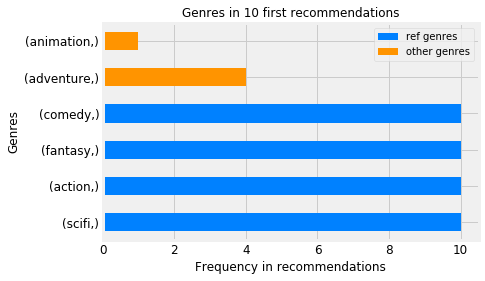

In [124]:
# Process recommendation genres
genres_recommendation = recom_genres(genres_kw_df.loc[movie_id, :].genres, recom_df)
# Define vector for colors
my_data = [myblue]*n_genres + (genres_recommendation.shape[0] - n_genres)*[myorange]
# Plot bar plot
genres_recommendation.plot.barh(color=my_cmap(my_norm(my_data)), fontsize=12)
# Get axes for graph tuning
ax = plt.gca()
# Set legend elements
legend_elements = [Patch(facecolor=my_cmap(my_norm([3]))[0], label='ref genres'),
                   Patch(facecolor=my_cmap(my_norm([9]))[0], label='other genres')]
# Create handmade legend
ax.legend(handles=legend_elements)
# Set axis labels and title
ax.set_xlabel("Frequency in recommendations", fontsize=12)
ax.set_ylabel("Genres", fontsize=12)
ax.set_title("Genres in 10 first recommendations", fontsize=12);

The blue genres are the genres of the reference movie (here 'Batman & Robin'). The more those genres are represented in the recommendations, the more close to the reference movie's genres the recommendations are.

Another genre well represented in the recommendation here is adventure, which is quite appropriate as well for our reference movie.

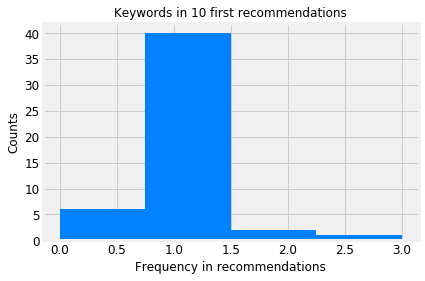

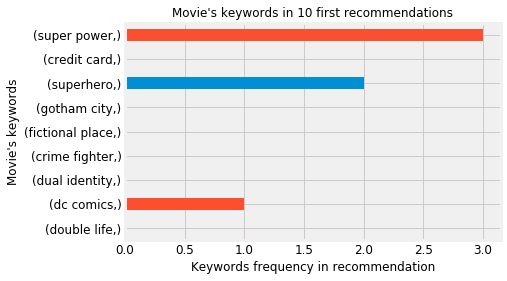

In [125]:
# Process recomendation keywords
keywords_recommendation = recom_kw(genres_kw_df.loc[movie_id, :].keywords, recom_df)
# Define vector for colors
my_data = [myblue]*n_kw + (keywords_recommendation.shape[0] - n_kw)*[myorange]

# Plot
# First plot : movie's keywords histogram
fig, ax = plt.subplots()
ax = keywords_recommendation.plot.hist(color=my_cmap(my_norm(my_data)), fontsize=12, bins=len(keywords_recommendation.unique()))
# Set axis labels and title
ax.set_xlabel("Frequency in recommendations", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)
ax.set_title("Keywords in 10 first recommendations", fontsize=12)
# pyplot.locator_params(axis='x', nbins=3)

# Second plot : movie's keywords frequency
fig, ax = plt.subplots()
# Movie's keywords for barplot
movie_kw = keywords_recommendation.loc[genres_kw_df.loc[movie_id, :].kw_list]
ax = movie_kw.plot.barh(fontsize=12)
# Set axis labels and title
ax.set_xlabel("Keywords frequency in recommendation", fontsize=12)
ax.set_ylabel("Movie's keywords", fontsize=12)
ax.set_title("Movie's keywords in 10 first recommendations", fontsize=12);

The first plot shows that among the numerous keywords associated with our 10 recommendations movies, most are only appearing once. HOWEVER, the second plot shows the keywords associated to our reference movie, and how many times those came out of the recommendations.

The more frequent keywords are in the second plot, the closer recommendations movies keywords are to the reference movie keywords.

Here we can see that the model came out with super power or superhero movies, but also with dc-comics movies (and not marvel movies for instance) wich is really interesting behaviour.

# 8) Visualisations

We will try to look at the embedding space of our movies titles, in order to make (hopefully) gatherings. For this task we will use TSNE manifold algorithm, projected on the 2 principal components of our embedded space in order to be able to visualize the space.

TSNE

In [126]:
tsne_test = manifold.TSNE(n_components=2, perplexity=50, n_iter=1000, metric='cosine').fit_transform(movies_weights)

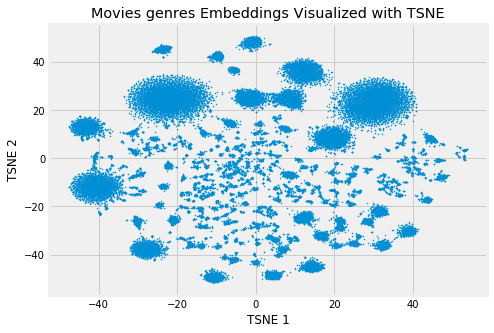

In [127]:
plt.figure(figsize = (7, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], s=1)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

At first glence once can see many clusters, but let's be careful before jumping to conclusions with TSNE outputs which are known to be as magical as difficult to master.

#### KMEANS clustering on movies weights

Clustering helps us emphasize clusters and then look for sense in those

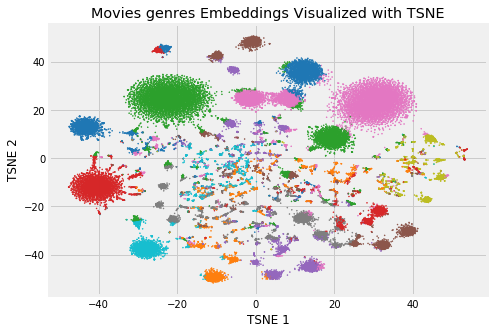

In [128]:
kmeans = cluster.KMeans(n_clusters=20)
kmeans = kmeans.fit(movies_weights)
categs_kmeans = kmeans.predict(movies_weights)
plt.figure(figsize = (7, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=categs_kmeans, s=1,cmap=plt.cm.tab10)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

In [166]:
def aregenres(genres_row, genres_list):
    aregenre = False
    if (len(genres_row) == len(genres_list)) & (np.intersect1d(genres_row, genres_list).shape[0] == len(genres_list)):
        aregenre = True
    if aregenre:
        out = 1
    else:
        out = 0
    return out

def find_genres(genres_list, df, plot):  
    # Build a test vector for the 'genres' list
    test_genres = df.genres_list.apply(aregenres, args=(genres_list,))
    sizes_genres = test_genres.apply(lambda x: 0.1 if x == 0 else 10)
    # Plot
    plt.figure(figsize = (10, 7))
    plt.scatter(plot[:, 0], plot[:, 1], c=cmap_2c(norm_2c(test_genres.values)), s=sizes_genres)
    plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

Trying to identify what is the SOUTH cluster

In [130]:
ids_south_cluster = np.where((tsne_test[:, 0] < -5) & (tsne_test[:, 0] > -15) & (tsne_test[:, 1] < -40))[0]
genres_kw_df.loc[ids_south_cluster, ['title', 'genres', 'keywords']]

,title,genres,keywords
114,The Ring,"horror,mystery","journalist,drowning,island,television,horse,in..."
126,Jaws 2,"horror,thriller","mayor,island,shark attack,police chief,sailing..."
135,Silent Hill,"horror,mystery","monster,symbolism,mother role,burning of witch..."
166,The Ninth Gate,"horror,mystery,thriller","new york,obsession,passion for collection,sout..."
179,Angel Heart,"horror,mystery,thriller","southern usa,amnesia,drug addiction,new orlean..."
234,The Shining,"horror,thriller","hotel,montana,isolation,hotelier,oregon,colora..."
279,From Hell,"horror,mystery,thriller","london england,loss of loved one,drug addictio..."
302,The Fog,"horror,thriller","california,prophecy,fire,sea,beach,parent chil..."
305,The Omen,"horror,thriller","monk,prophecy,ambassador,nanny,rottweiler,devi..."
455,Halloween,"horror,thriller","mask,babysitter,halloween,police,psychopathic ..."


Looks like horror AND thriller to me ! Now check our hypothesis : let's identify the horror + thriller movies

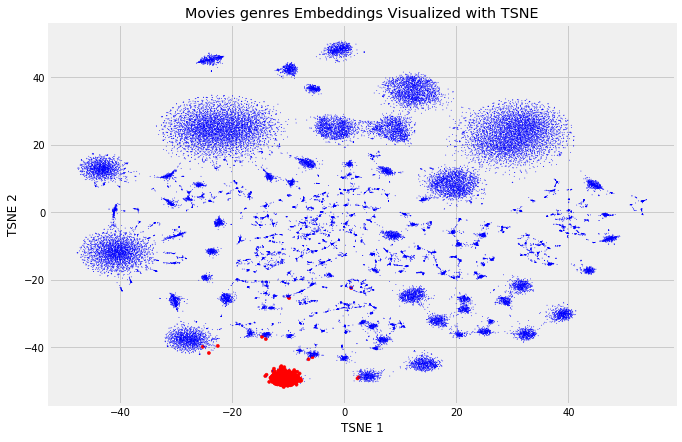

In [167]:
find_genres(['horror', 'thriller'], genres_kw_df, tsne_test)

Trying to identify what is the WEST cluster

In [153]:
ids_west_cluster = np.where((tsne_test[:, 0] < -35) & (tsne_test[:, 1] > -20) & (tsne_test[:, 1] < 0))[0]
genres_kw_df.loc[ids_west_cluster, ['title', 'genres', 'keywords']]

,title,genres,keywords
62,Grizzly Man,documentary,"life and death,camping,rain,camcorder,self-aba..."
88,Stuttgart Shanghai,documentary,"parent child relationship,culture clash,move,s..."
211,Nanook of the North,documentary,"canada,winter,ice,fishing,polar zone,harpoon,i..."
219,Olympia Part One: Festival of the Nations,documentary,"olympic games,nazi,national socialism,national..."
225,Olympia Part Two: Festival of Beauty,documentary,"gymnastics,nationalism,olympic games,nazi,nati..."
285,Workers Leaving the Lumière Factory,documentary,"factory worker,factory,lyon,closing time,histo..."
564,A Brief History of Time,documentary,"based on novel or book,time,black hole,biograp..."
591,The Way Things Go,documentary,"experiment,visual arts,garbage,rube goldberg,d..."
594,Born into Brothels,documentary,"prostitute,red-light disctrict,human trafficki..."
598,Wege Gottes,documentary,"odessa,woman director,street kid"


Looks like documentaries to me ! Now check our hypothesis : let's identify the documentaries movies

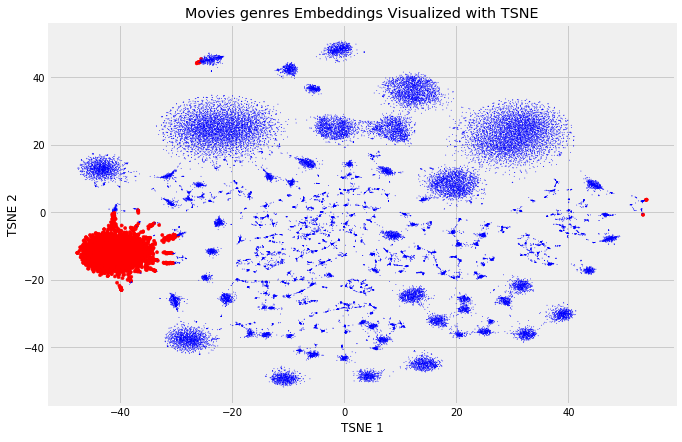

In [168]:
find_genres(['documentary'], genres_kw_df, tsne_test)

Trying to identify what is the NORTH cluster

In [155]:
ids_north_cluster = np.where((tsne_test[:, 0] < 5) & (tsne_test[:, 0] > -5) & (tsne_test[:, 1] > 40))[0]
genres_kw_df.loc[ids_north_cluster, ['title', 'genres', 'keywords']]

,title,genres,keywords
630,Regoch,animation,"mythology,fairy"
1765,Barcode,animation,nan
1861,Candy Boy,animation,"pollution,orphanage,marijuana,student,dead fis..."
2054,Blondie & Dagwood,animation,nan
2701,Animated Epics: Beowulf,animation,"weapon,epic"
2954,The Boy Who Saw the Iceberg,animation,"iceberg,ship,boy"
5009,Pokémon: The First Movie - Mewtwo Strikes Back,animation,"revenge,pokémon,creator,researcher,research la..."
5152,Käpt'n Blaubär - Der Film,animation,"sea,captain,bear"
7549,The Very First Noel,animation,"jesus christ,three kings,bethlehem"
8720,WordWorld: The Race to Mystery Island,animation,nan


Looks like animation movies to me ! Now check our hypothesis : let's identify the animation movies

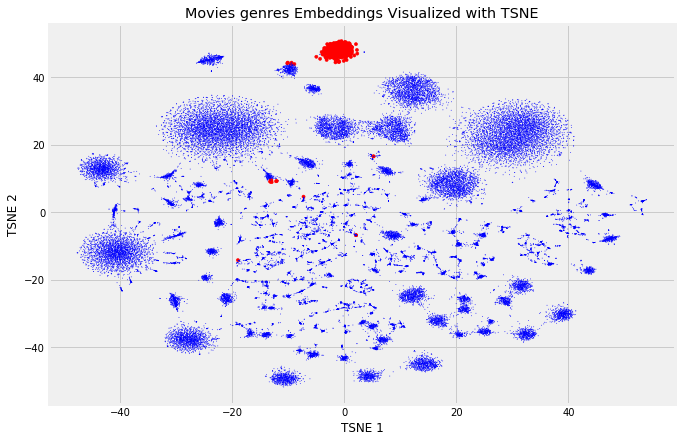

In [169]:
find_genres(['animation'], genres_kw_df, tsne_test)

Trying to identify what is the large NORTH WEST cluster

In [157]:
ids_middle_cluster = np.where((tsne_test[:, 0] < -10) & (tsne_test[:, 0] > -30) & (tsne_test[:, 1] > 15) & (tsne_test[:, 1] < 35))[0]
genres_kw_df.loc[ids_middle_cluster, ['title', 'genres', 'keywords']]

,title,genres,keywords
8,Mon Oncle,comedy,"paris france,city portrait,factory worker,pare..."
33,Go for Zucker,comedy,"berlin germany,berlin wall,sibling relationshi..."
256,Train Birds,comedy,"detective inspector,suspicion of murder,laplan..."
271,The Mad Adventures of Rabbi Jacob,comedy,"paris france,new york,red hair,airport,jewry,p..."
272,The Wing or the Thigh,comedy,"circus,double life,restaurant,fast food restau..."
289,Monsieur Hulot's Holiday,comedy,"holiday,underdog,hotel,beach,jazz,tennis,maske..."
324,Airplane!,comedy,"chicago,alcohol,cataclysm,guitar,medicine,taxi..."
375,Cool Runnings,comedy,"winter,trainer,olympic games,jamaica,training ..."
388,The Punch Bowl,comedy,"graduation,punch"
421,The Bank Dick,comedy,"california,daughter,bank robbery,car chase,alc..."


Looks like comedy movies to me ! Now check our hypothesis : let's identify the comedy movies

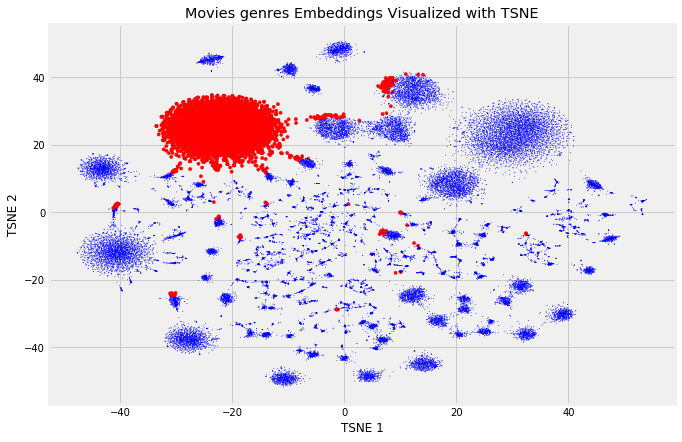

In [170]:
find_genres(['comedy'], genres_kw_df, tsne_test)

looking for drama movies ?

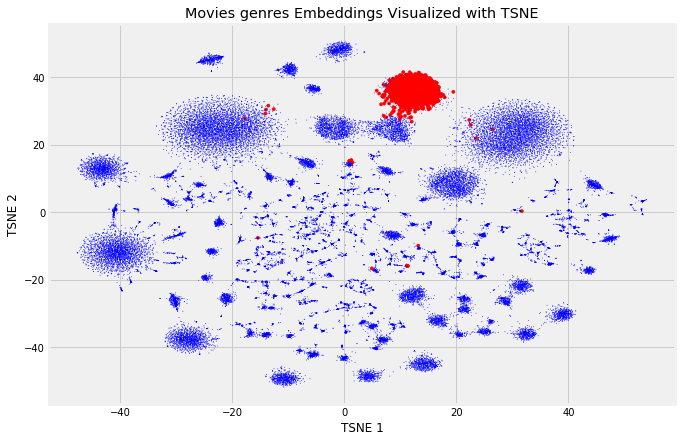

In [191]:
find_genres(['drama', 'comedy'], genres_kw_df, tsne_test)

In [222]:
def plot_movie(movie_id, df, plot):  
    sizes = [0.1] * df.shape[0]
    sizes[movie_id] = 100
    # Plot
    plt.figure(figsize = (10, 7))
    plt.scatter(plot[:, 0], plot[:, 1], c=cmap_2c(norm_2c(sizes)), s=sizes)
    plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

In [339]:
find_movie('elysium', genres_kw_df)

,title,genres,keywords,genres_list,kw_list
33556,Elysium,"animation,scifi",nan,"[animation, scifi]",[]
44380,Elysium,"scifi,action,drama,thriller","dystopia,space station,class conflict","[scifi, action, drama, thriller]","[dystopia, space station, class conflict]"


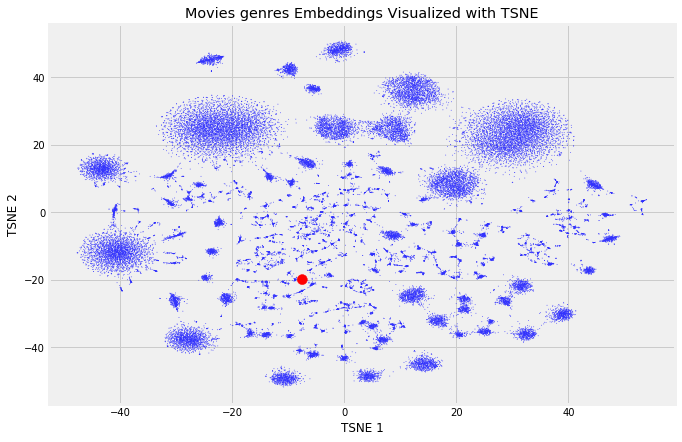

In [340]:
plot_movie(44380, genres_kw_df, tsne_test)

## Try to color the mapping with most common keywords

Building genres combinations counts

In [254]:
# Gather all genres combinations from all movies
movies_genres_lists = genres_kw_df.genres_list.values.tolist()
movies_genres_lists = [sorted(g_list) for g_list in movies_genres_lists]
# Count occurences
val, counts = np.unique(np.array(movies_genres_lists), return_counts=True)
# Create array for best import to dataframe
count_array = np.hstack([val.reshape(-1,1), counts.reshape(-1,1)])
# Create dataframe
genres_count_df = pd.DataFrame(count_array, columns=['genres', 'counts'])
genres_count_df.loc[:, 'counts'] = genres_count_df.loc[:, 'counts'].astype(int)
genres_count_df = genres_count_df.sort_values('counts', ascending=False)
genres_count_df.head(20)

,genres,counts
1092,[comedy],5070
1497,[drama],4811
1446,[documentary],2826
1638,"[drama, romance]",1800
1163,"[comedy, drama]",1710
1785,[music],1402
1752,[horror],1379
1335,"[comedy, romance]",1227
1230,"[comedy, drama, romance]",1118
935,[animation],693


A few genres are frequent, most are rare

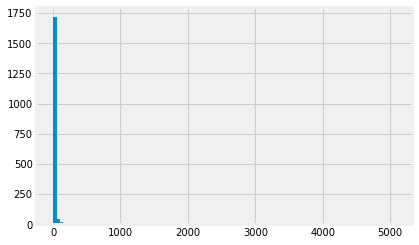

In [256]:
genres_count_df.loc[:, 'counts'].hist(bins=100);

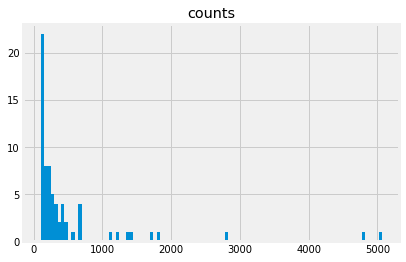

In [257]:
genres_count_df[genres_count_df.loc[:, 'counts'] > 100].hist(bins=100);

Get 19 most common genres combinations

In [258]:
index_most_common_genres = {",".join(genre) : idw for idw, genre in enumerate(genres_count_df.head(19).genres.values)}
index_most_common_genres['other'] = 19
index_most_common_genres

{'comedy': 0,
 'drama': 1,
 'documentary': 2,
 'drama,romance': 3,
 'comedy,drama': 4,
 'music': 5,
 'horror': 6,
 'comedy,romance': 7,
 'comedy,drama,romance': 8,
 'animation': 9,
 'crime,drama': 10,
 'horror,thriller': 11,
 'drama,thriller': 12,
 'action': 13,
 'documentary,music': 14,
 'action,thriller': 15,
 'action,drama': 16,
 'thriller': 17,
 'animation,family': 18,
 'other': 19}

In [259]:
def input_color(genres_list, target, value):
    genres_target = target.split(",")
    if (len(genres_target) == len(genres_list)) & (np.intersect1d(genres_target, genres_list).shape[0] == len(genres_list)):
        return value
    else:
        return 19

In [260]:
movies_genres_kw_df = genres_kw_df.loc[:, ['title', 'genres_list', 'kw_list']]
for genres, value in index_most_common_genres.items():
    movies_genres_kw_df.loc[:, genres] = genres_kw_df.genres_list.apply(input_color, args=(genres, value))

In [261]:
def select_color(row):
    if (row == 19).astype(int).sum() != 20:
        return row[row != 19].values[0]
    else:
        return 19
movies_genres_kw_df.loc[:, 'colors'] = movies_genres_kw_df.iloc[:, 3:].apply(select_color, axis=1)
movies_genres_kw_df.loc[:, 'sizes'] = movies_genres_kw_df.colors.apply(lambda x: 1 if x == 19 else 10)

In [264]:
movies_common_genre_sample = {}
for genres, color in index_most_common_genres.items():
    movie_color_sample = movies_genres_kw_df.loc[:, 'colors'][movies_genres_kw_df.loc[:, 'colors'] == color]
    tsne_coordinates = tsne_test[movie_color_sample.index.values]
    movies_common_genre_sample[genres] = np.percentile(tsne_coordinates, 50, axis=0)

While we plot the result we label the 19 most common keywords from the median of the coordinates of the movies related to those popular keywords, which is therefore approximation but precise-enough to label most obvious clusters

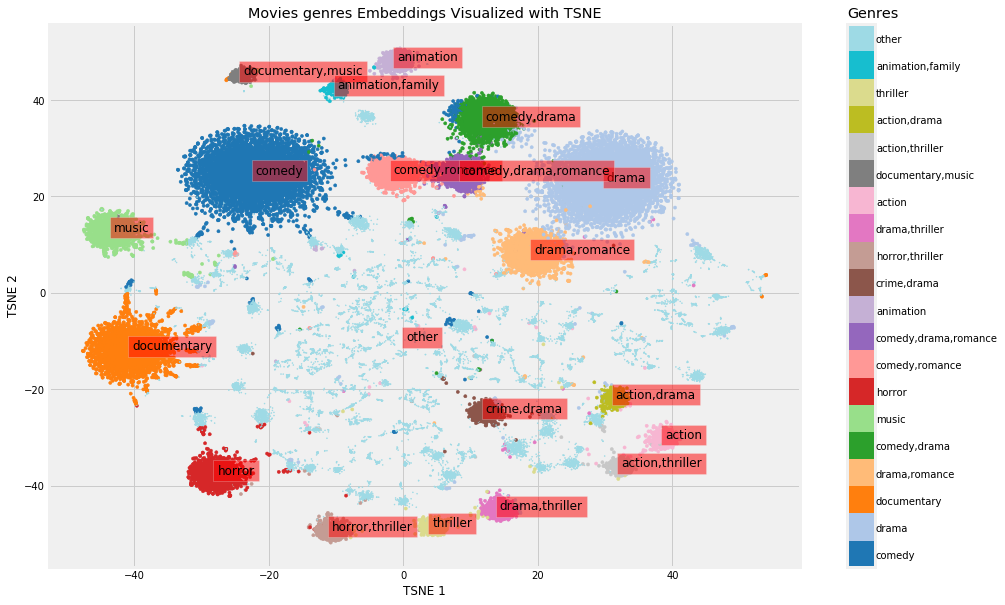

In [338]:
# Plot
plt.figure(figsize = (15, 10))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=movies_genres_kw_df.colors, cmap=cm.get_cmap('tab20'), s=movies_genres_kw_df.sizes)
ax = plt.gca()
ax.set_xlabel('TSNE 1');
ax.set_ylabel('TSNE 2');
ax.set_title('Movies genres Embeddings Visualized with TSNE')
# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(list(index_most_common_genres.keys())):
    cbar.ax.text(20, 0.3 + j * 0.95, lab)
cbar.ax.set_title('Genres', loc = 'left')
for kw, (x, y) in movies_common_genre_sample.items():
    plt.text(s=kw, x=x, y=y, bbox=dict(facecolor='red', alpha=0.5), fontsize=12);

In [329]:
genres_kw_df[genres_kw_df.genres == 'adventure,scifi'].title.values

array(['Lost in Space', 'Fantastic Voyage', 'The Lost World',
       'Clockmaker', 'Mysterious Island', 'The Angry Red Planet',
       'The Thief Lord',
       'I.M.P.S. The Relentless - Chapter 1: Davenport Gateway',
       'Dragon Storm', 'Spacehunter: Adventures in the Forbidden Zone',
       'Unknown World', 'Circuitry Man II: Plughead Rewired',
       'First Men in the Moon', 'The 8th Day',
       'The Incredible Petrified World', 'Earth Star Voyager',
       'Glen and Randa', 'The Lost Future',
       'Bikini Girls on Dinosaur Planet', '2033', 'The Last Dinosaur'],
      dtype=object)

# 9) Testing plan

We aim to test our recommender system with the following:

- 1) 100 movies of 'drama' type
- 2) 100 movies of 'comedy' type
- 3) 100 movies of 'drama' type and another type
- 4) 100 movies of 'comedy' type and another type
- 5) 100 movies of 'drama' type and two others type
- 6) 100 movies of 'comedy' type and two others type
- 7) 100 movies with the 'woman director' keyword (most common)
- 8) 100 movies with the 'revenge' keyword (quite common)
- 9) 100 movies with the 'robot' keyword (less common, only 102 occurences)
- 10) 20 movies with the 'skyscraper' keyword (rare, only 20 occurences)

**The plotting may be boring and I recommend to the reader to jump to conclusion of this chapter 9)**

In [267]:
drama_movies = genres_kw_df[genres_kw_df.genres == 'drama'].sample(100, random_state=0)
comedy_movies = genres_kw_df[genres_kw_df.genres == 'comedy'].sample(100, random_state=0)
drama2_ind = genres_kw_df.genres_list.apply(lambda x: True if (len(x) == 2) and ('drama' in x) else False)
drama2_movies = genres_kw_df.loc[drama2_ind, :].sample(100, random_state=0)
comedy2_ind = genres_kw_df.genres_list.apply(lambda x: True if (len(x) == 2) and ('comedy' in x) else False)
comedy2_movies = genres_kw_df.loc[comedy2_ind, :].sample(100, random_state=0)
drama3_ind = genres_kw_df.genres_list.apply(lambda x: True if (len(x) == 3) and ('drama' in x) else False)
drama3_movies = genres_kw_df.loc[drama3_ind, :].sample(100, random_state=0)
comedy3_ind = genres_kw_df.genres_list.apply(lambda x: True if (len(x) == 3) and ('comedy' in x) else False)
comedy3_movies = genres_kw_df.loc[comedy3_ind, :].sample(100, random_state=0)

In [268]:
woman_director_movies = genres_kw_df[genres_kw_df['keywords'].str.contains('woman director')].sample(100, random_state=0)
revenge_movies = genres_kw_df[genres_kw_df['keywords'].str.contains('revenge')].sample(100, random_state=0)
robot_movies = genres_kw_df[genres_kw_df['keywords'].str.contains('robot')].sample(100, random_state=0)
skyscraper_movies = genres_kw_df[genres_kw_df['keywords'].str.contains('skyscraper')].sample(20, random_state=0)

In [269]:
dramas_genres_ac = []
dramas_kw_ac = []
comedy_genres_ac = []
comedy_kw_ac = []
keywords_genres_ac = []
keywords_kw_ac = []

### 9.1) Drama movies test

Movie 100 / 100

Genres accuracy : 0.96
Keywords accuracy : 0.01


/home/noel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


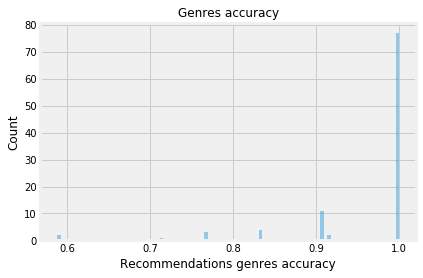

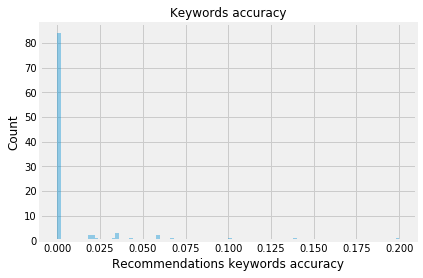

In [270]:
gac, kwac = recommender_behaviour_study(drama_movies, genres_kw_df)   
dramas_genres_ac.append(gac)
dramas_kw_ac.append(kwac)

### 9.2) Comedy movies test

Movie 100 / 100

Genres accuracy : 0.97
Keywords accuracy : 0.00


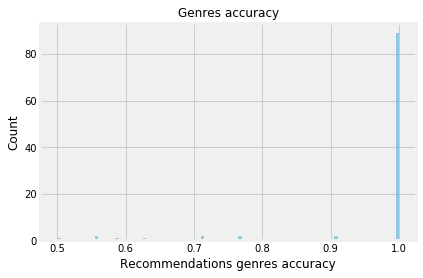

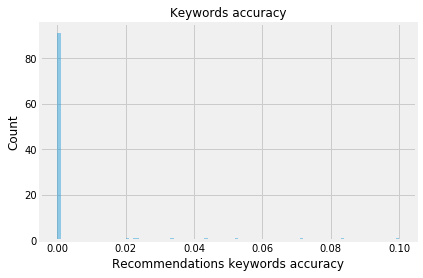

In [271]:
gac, kwac = recommender_behaviour_study(comedy_movies, genres_kw_df)
comedy_genres_ac.append(gac)
comedy_kw_ac.append(kwac)

### 9.3) Drama + another genre movies test

Movie 100 / 100

Genres accuracy : 0.97
Keywords accuracy : 0.01


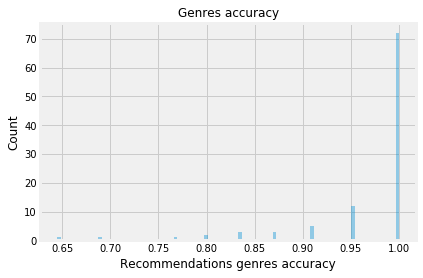

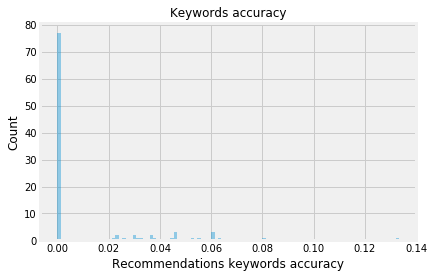

In [272]:
gac, kwac = recommender_behaviour_study(drama2_movies, genres_kw_df)
dramas_genres_ac.append(gac)
dramas_kw_ac.append(kwac)

### 9.4) Comedy  + another genre movies test

Movie 100 / 100

Genres accuracy : 0.98
Keywords accuracy : 0.02


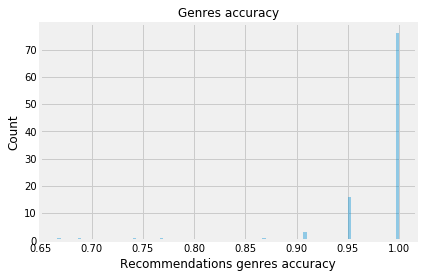

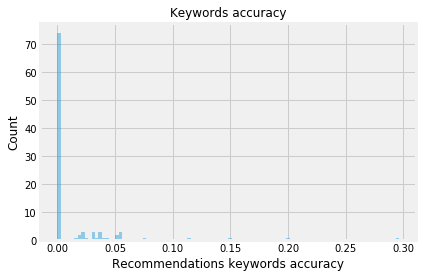

In [273]:
gac, kwac = recommender_behaviour_study(comedy2_movies, genres_kw_df)
comedy_genres_ac.append(gac)
comedy_kw_ac.append(kwac)

### 9.5) Drama + 2 others genres movies test

Movie 100 / 100

Genres accuracy : 0.97
Keywords accuracy : 0.01


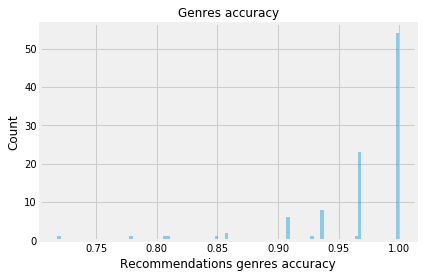

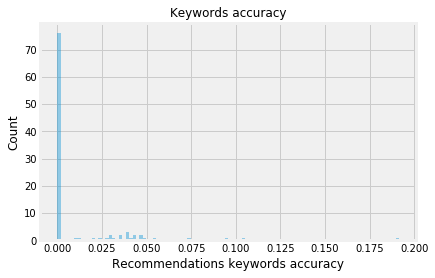

In [274]:
gac, kwac = recommender_behaviour_study(drama3_movies, genres_kw_df)
dramas_genres_ac.append(gac)
dramas_kw_ac.append(kwac)

### 9.6) Comedy + 2 others genres movies test

Movie 100 / 100

Genres accuracy : 0.97
Keywords accuracy : 0.01


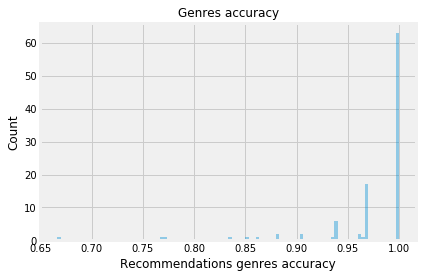

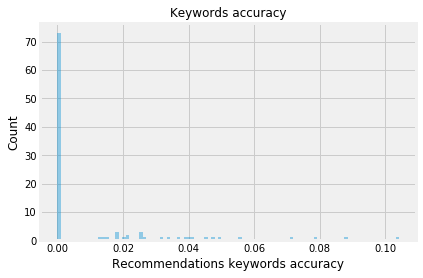

In [275]:
gac, kwac = recommender_behaviour_study(comedy3_movies, genres_kw_df)
comedy_genres_ac.append(gac)
comedy_kw_ac.append(kwac)

### 9.7) woman director movies test

Movie 100 / 100

Genres accuracy : 0.96
Keywords accuracy : 0.03


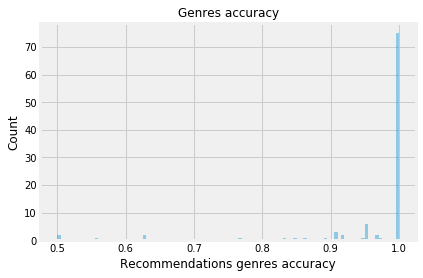

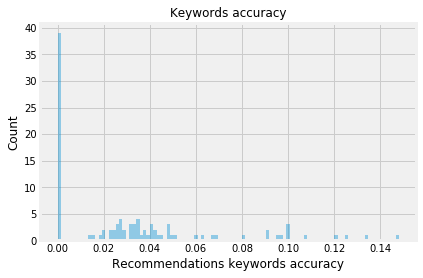

In [276]:
gac, kwac = recommender_behaviour_study(woman_director_movies, genres_kw_df)
keywords_genres_ac.append(gac)
keywords_kw_ac.append(kwac)

### 9.8) revenge movies test

Movie 100 / 100

Genres accuracy : 0.96
Keywords accuracy : 0.03


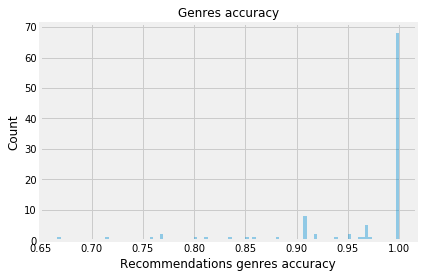

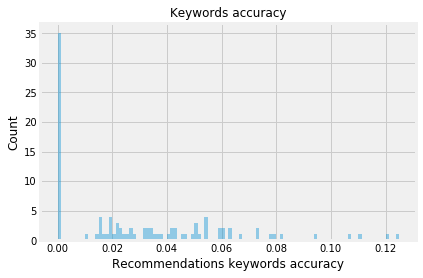

In [277]:
gac, kwac = recommender_behaviour_study(revenge_movies, genres_kw_df)
keywords_genres_ac.append(gac)
keywords_kw_ac.append(kwac)

### 9.9) robot movies test

Movie 100 / 100

Genres accuracy : 0.94
Keywords accuracy : 0.03


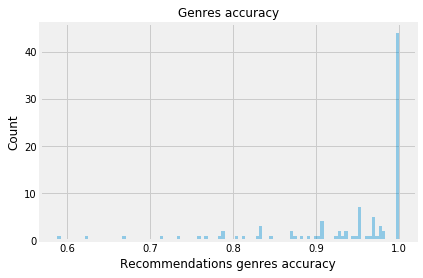

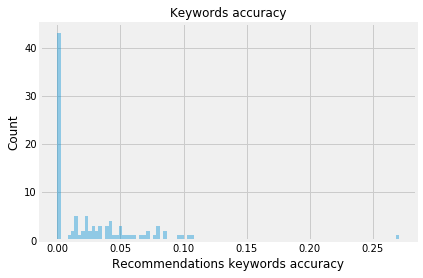

In [278]:
gac, kwac = recommender_behaviour_study(robot_movies, genres_kw_df)
keywords_genres_ac.append(gac)
keywords_kw_ac.append(kwac)

### 9.10) skyscraper movies test

Movie 20 / 20

Genres accuracy : 0.99
Keywords accuracy : 0.02


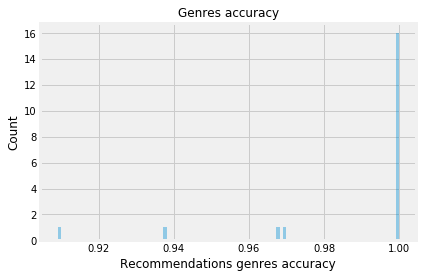

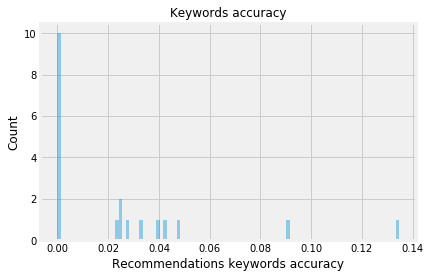

In [279]:
gac, kwac = recommender_behaviour_study(skyscraper_movies, genres_kw_df)
keywords_genres_ac.append(gac)
keywords_kw_ac.append(kwac)

### 9.11) Conclusion : Influence of multiple genres and keyword frequency on recommendations

As we did not try lots of combinations, this can be named 'conclusion' but should more be considered as 'first idea of what is going on here'

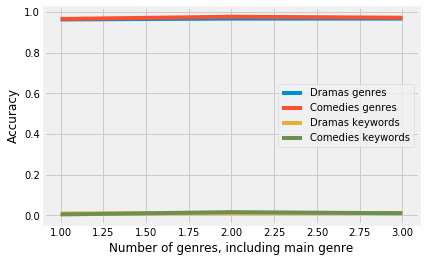

In [280]:
n_genres = [1, 2, 3]
plt.plot(n_genres, dramas_genres_ac, label='Dramas genres')
plt.plot(n_genres, comedy_genres_ac, label='Comedies genres')
plt.plot(n_genres, dramas_kw_ac, label='Dramas keywords')
plt.plot(n_genres, comedy_kw_ac, label='Comedies keywords')
ax = plt.gca()
ax.set_xlabel("Number of genres, including main genre")
ax.set_ylabel("Accuracy")
ax.legend();

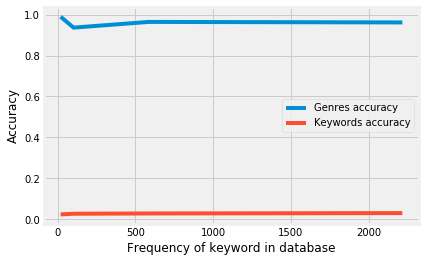

In [281]:
kw_freq = kw_count_df.loc[:, 'count'][kw_count_df.kw.isin(['woman director', 'revenge', 'robot', 'skyscraper'])]
plt.plot(kw_freq, keywords_genres_ac, label='Genres accuracy')
plt.plot(kw_freq, keywords_kw_ac, label='Keywords accuracy')
ax = plt.gca()
ax.set_xlabel("Frequency of keyword in database")
ax.set_ylabel("Accuracy")
ax.legend();

#### We built a genres predicting recommender, nothing else

# 10) Studying recommendations from embedding and nearest neighbors methods

In each of the 6 examples we study here, the nearest neighbor model trained on one-hot encoded strings of genres and keywords is actually not too bad in recommending movies with identic genres. It might not be shocking as the very sparse matrix will have more ones in the different genres strings columns than in the keywords strings columns, because there is less combinations of genres than there is of keywords.

However and as expected, this model is clueless about recommending keywords (accuracte recommendations may be lucky).

Our embedding model is acting the other way around, recommending from keywords and as a consequence, recommending accurate-enough genres.

## 1) Batman & Robin

In [300]:
movie_ref = 'Batman & Robin'
idx_movie_ref = genres_kw_df[genres_kw_df.title == movie_ref].index[0]
movie_ref = genres_kw_df.loc[idx_movie_ref, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_nn = ['Mission: Impossible II', 'Spider-Man 3', 'Open Your Eyes', 'Olympia Part Two: Festival of Beauty', 'One Million B.C.']
# Extract weights
recommendation, movies_weights = extract_embedding(layer, idx_movie_ref)
# Get recommendations (closest movies)
recom_df = genres_kw_df.loc[recommendation[1:], ['title', 'genres', 'keywords']]
recom_emb = recom_df.title[:5]
recom_nn_df = genres_kw_df[genres_kw_df.title.isin(recom_nn)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_emb_df = genres_kw_df[genres_kw_df.title.isin(recom_emb)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]

### 1.1) Nearest neighbors

Genres accuracy : 0.36


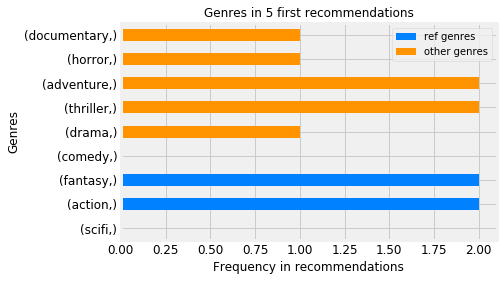

In [301]:
recom_genres_study(movie_ref, recom_nn_df)

Keywords accuracy : 0.03


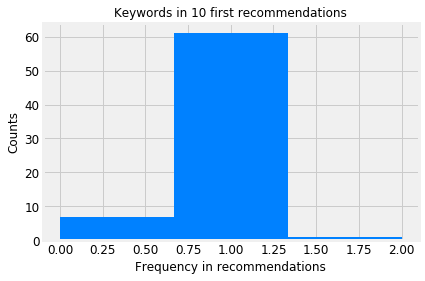

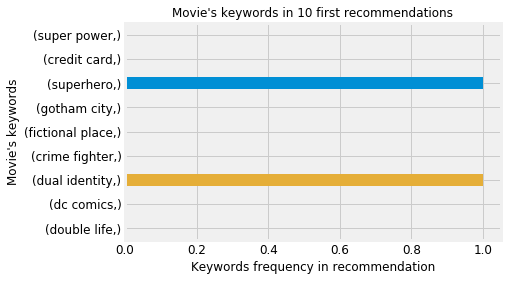

In [302]:
recom_kw_study(movie_ref, recom_nn_df)

### 1.2) Word embedding

Genres accuracy : 0.95


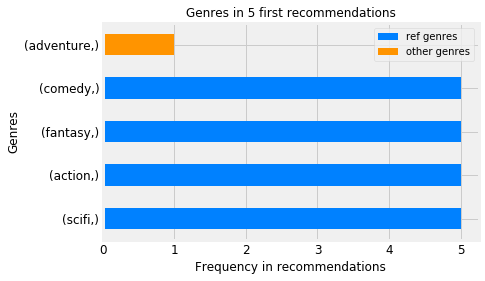

In [303]:
recom_genres_study(movie_ref, recom_emb_df)

Keywords accuracy : 0.00


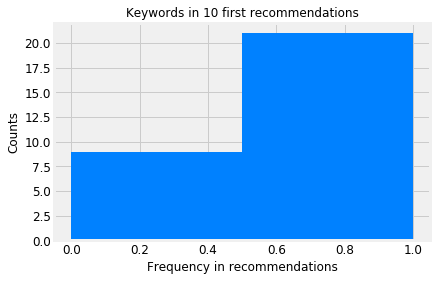

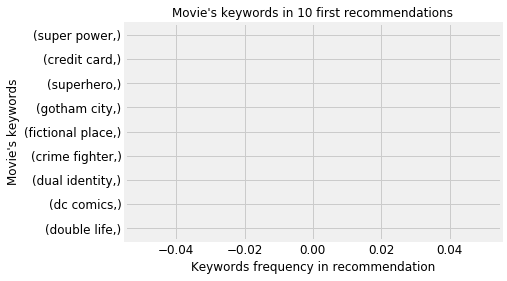

In [304]:
recom_kw_study(movie_ref, recom_emb_df)

## 2) X-Men

In [295]:
movie_ref = 'X-Men'
idx_movie_ref = genres_kw_df[genres_kw_df.title == movie_ref].index[0]
movie_ref = genres_kw_df.loc[idx_movie_ref, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_nn = ['Return of the Jedi', 'Journey 2: The Mysterious Island', 'Gamera vs. Viras', 'Ra.One', 'The Empire Strikes Back']
# Extract weights
recommendation, movies_weights = extract_embedding(layer, idx_movie_ref)
# Get recommendations (closest movies)
recom_df = genres_kw_df.loc[recommendation[1:], ['title', 'genres', 'keywords']]
recom_emb = recom_df.title[:5]
recom_nn_df = genres_kw_df[genres_kw_df.title.isin(recom_nn)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_emb_df = genres_kw_df[genres_kw_df.title.isin(recom_emb)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]

### 2.1) Nearest neighbors

Genres accuracy : 1.00


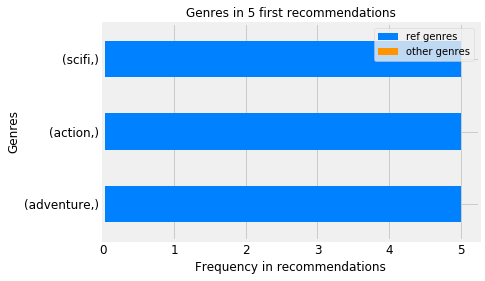

In [296]:
recom_genres_study(movie_ref, recom_nn_df)

Keywords accuracy : 0.02


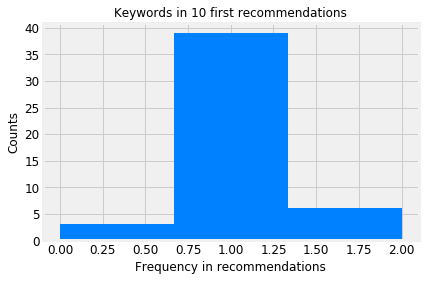

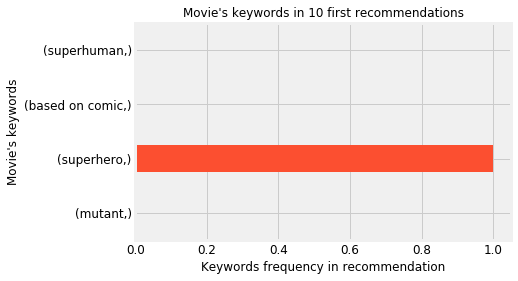

In [297]:
recom_kw_study(movie_ref, recom_nn_df)

### 2.2) Word embedding

Genres accuracy : 0.85


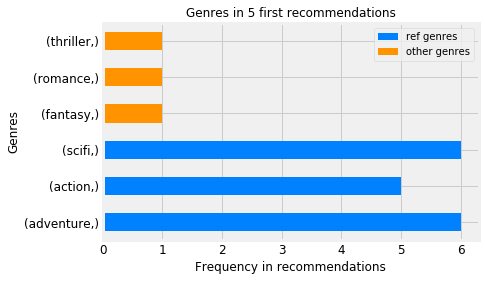

In [298]:
recom_genres_study(movie_ref, recom_emb_df)

Keywords accuracy : 0.05


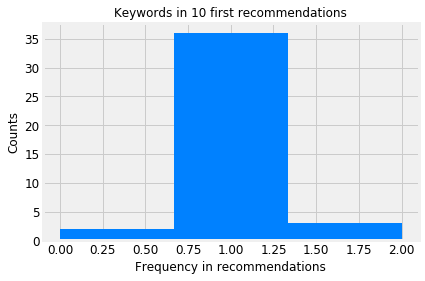

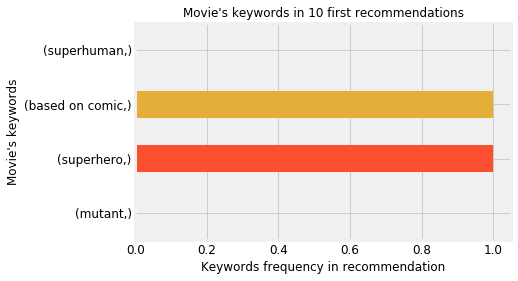

In [299]:
recom_kw_study(movie_ref, recom_emb_df)

## 3) Stargate

In [305]:
movie_ref = 'Stargate'
idx_movie_ref = genres_kw_df[genres_kw_df.title == movie_ref].index[0]
movie_ref = genres_kw_df.loc[idx_movie_ref, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_nn = [' Captain America: The First Avenger', 'Independence Day', 'Total Recall', 'Tycus', 'King Kong vs. Godzilla']
# Extract weights
recommendation, movies_weights = extract_embedding(layer, idx_movie_ref)
# Get recommendations (closest movies)
recom_df = genres_kw_df.loc[recommendation[1:], ['title', 'genres', 'keywords']]
recom_emb = recom_df.title[:5]
recom_nn_df = genres_kw_df[genres_kw_df.title.isin(recom_nn)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_emb_df = genres_kw_df[genres_kw_df.title.isin(recom_emb)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]

### 3.1) Nearest neighbors

Genres accuracy : 0.94


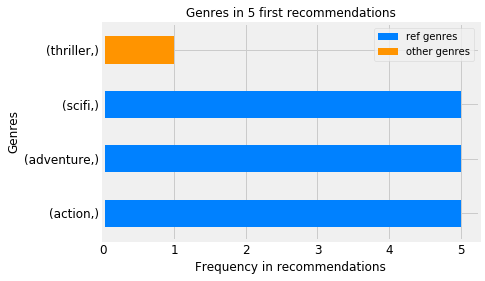

In [306]:
recom_genres_study(movie_ref, recom_nn_df)

Keywords accuracy : 0.00


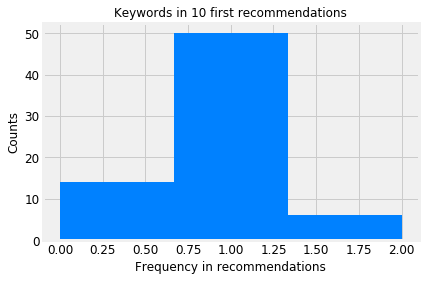

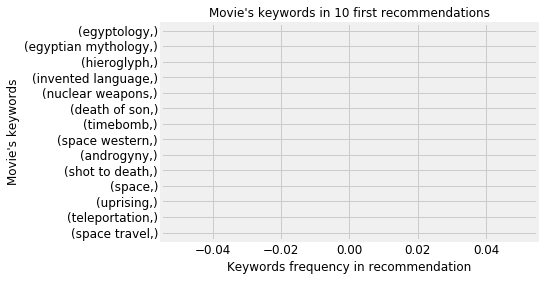

In [307]:
recom_kw_study(movie_ref, recom_nn_df)

### 3.2) Word embedding

Genres accuracy : 0.94


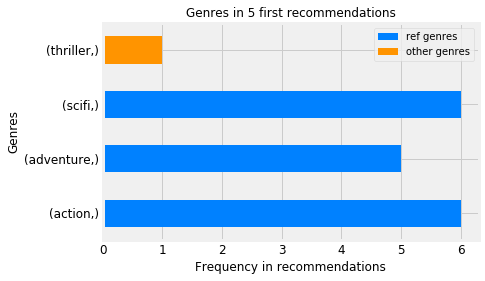

In [308]:
recom_genres_study(movie_ref, recom_emb_df)

Keywords accuracy : 0.00


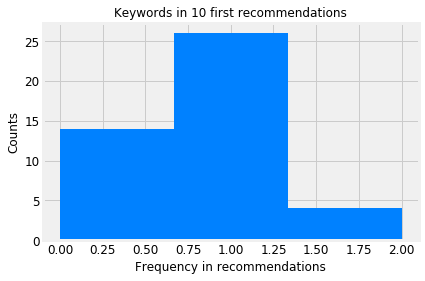

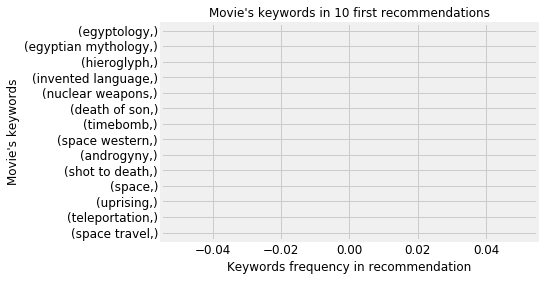

In [309]:
recom_kw_study(movie_ref, recom_emb_df)

## 4) The Good, the Bad and the Ugly 

In [310]:
movie_ref = 'The Good, the Bad and the Ugly'
idx_movie_ref = genres_kw_df[genres_kw_df.title == movie_ref].index[0]
movie_ref = genres_kw_df.loc[idx_movie_ref, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_nn = ['The Magnificent Seven', 'For a Few Dollars More', 'Tension at Table Rock', 'Open Range', 'Heaven with a Gun']
# Extract weights
recommendation, movies_weights = extract_embedding(layer, idx_movie_ref)
# Get recommendations (closest movies)
recom_df = genres_kw_df.loc[recommendation[1:], ['title', 'genres', 'keywords']]
recom_emb = recom_df.title[:5]
recom_nn_df = genres_kw_df[genres_kw_df.title.isin(recom_nn)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_emb_df = genres_kw_df[genres_kw_df.title.isin(recom_emb)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]

### 4.1) Nearest neighbors

Genres accuracy : 1.00


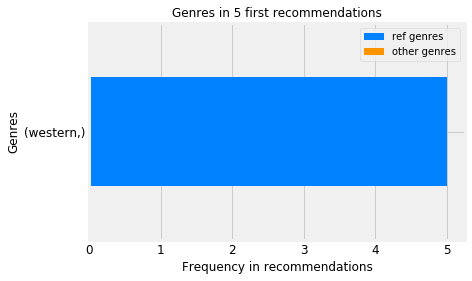

In [311]:
recom_genres_study(movie_ref, recom_nn_df)

Keywords accuracy : 0.06


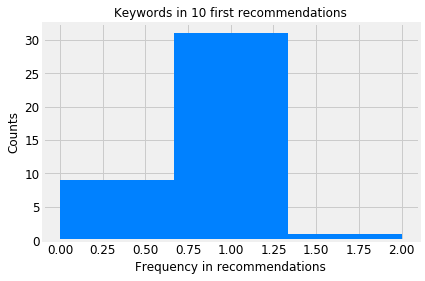

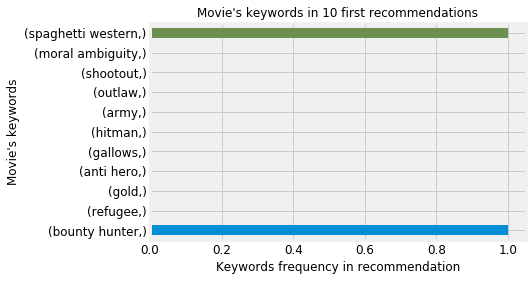

In [312]:
recom_kw_study(movie_ref, recom_nn_df)

### 4.2) Word embedding

Genres accuracy : 1.00


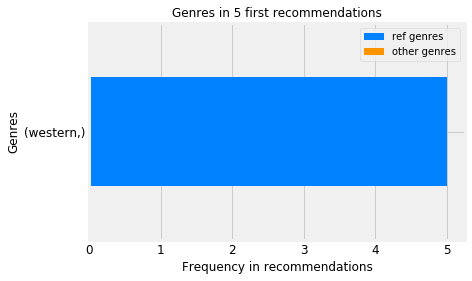

In [313]:
recom_genres_study(movie_ref, recom_emb_df)

Keywords accuracy : 0.00


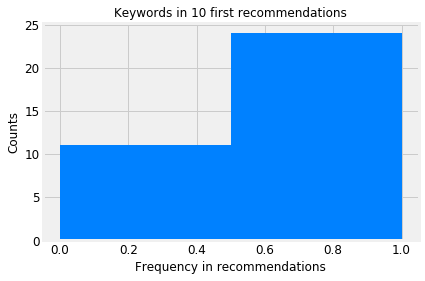

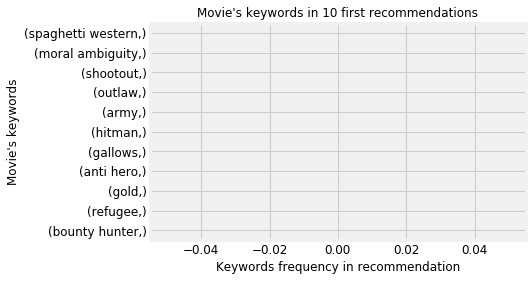

In [314]:
recom_kw_study(movie_ref, recom_emb_df)

## 5) Love Actually

In [315]:
movie_ref = 'Love Actually'
idx_movie_ref = genres_kw_df[genres_kw_df.title == movie_ref].index[0]
movie_ref = genres_kw_df.loc[idx_movie_ref, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_nn = ['Leatherheads', 'When Harry Met Sally...', 'Roman Holiday', "Bridget Jones's Diary", 'No Reservations']
# Extract weights
recommendation, movies_weights = extract_embedding(layer, idx_movie_ref)
# Get recommendations (closest movies)
recom_df = genres_kw_df.loc[recommendation[1:], ['title', 'genres', 'keywords']]
recom_emb = recom_df.title[:5]
recom_nn_df = genres_kw_df[genres_kw_df.title.isin(recom_nn)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_emb_df = genres_kw_df[genres_kw_df.title.isin(recom_emb)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]

### 5.1) Nearest neighbors

Genres accuracy : 1.00


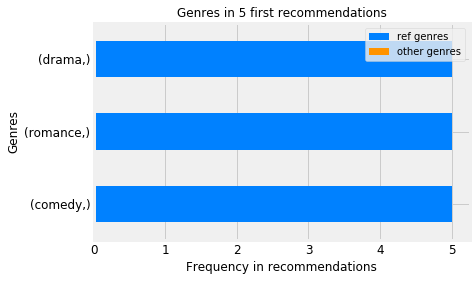

In [316]:
recom_genres_study(movie_ref, recom_nn_df)

Keywords accuracy : 0.05


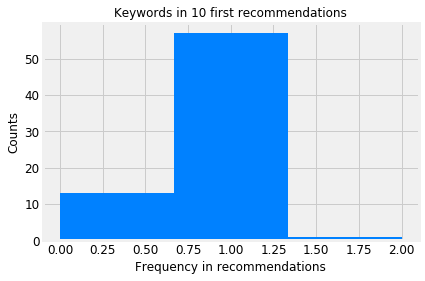

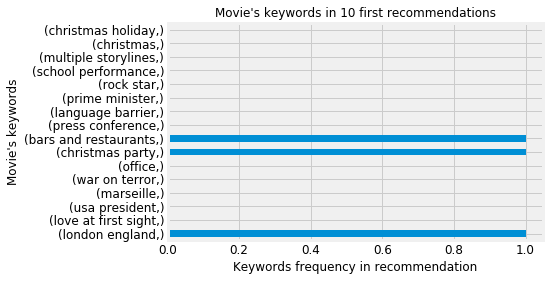

In [317]:
recom_kw_study(movie_ref, recom_nn_df)

### 5.2) Word embedding

Genres accuracy : 0.90


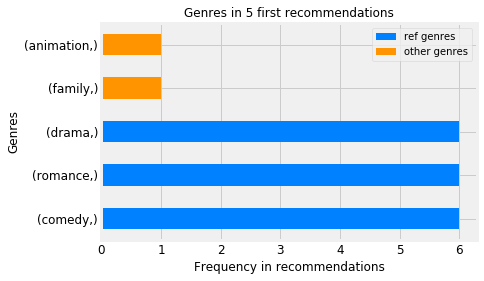

In [318]:
recom_genres_study(movie_ref, recom_emb_df)

Keywords accuracy : 0.08


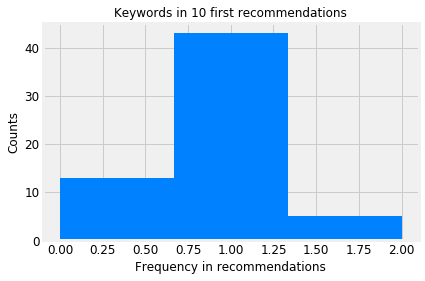

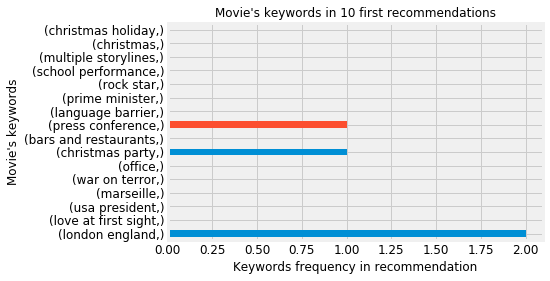

In [319]:
recom_kw_study(movie_ref, recom_emb_df)

## 6) Pearl Harbor

In [320]:
movie_ref = 'Pearl Harbor'
idx_movie_ref = genres_kw_df[genres_kw_df.title == movie_ref].index[0]
movie_ref = genres_kw_df.loc[idx_movie_ref, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_nn = [' Un Chien Andalou', 'A Fish Called Wanda', 'Trainspotting', 'The Killing Fields', 'Interview with the Vampire']
# Extract weights
recommendation, movies_weights = extract_embedding(layer, idx_movie_ref)
# Get recommendations (closest movies)
recom_df = genres_kw_df.loc[recommendation[1:], ['title', 'genres', 'keywords']]
recom_emb = recom_df.title[:5]
recom_nn_df = genres_kw_df[genres_kw_df.title.isin(recom_nn)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_emb_df = genres_kw_df[genres_kw_df.title.isin(recom_emb)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]

### 6.1) Nearest neighbors

Genres accuracy : 0.50


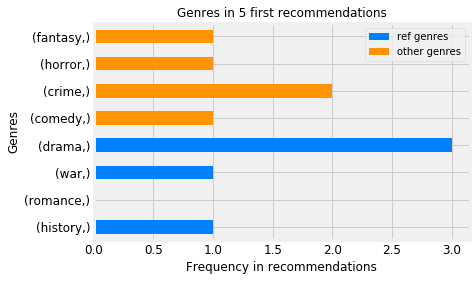

In [321]:
recom_genres_study(movie_ref, recom_nn_df)

Keywords accuracy : 0.00


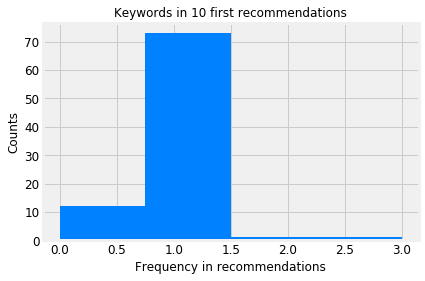

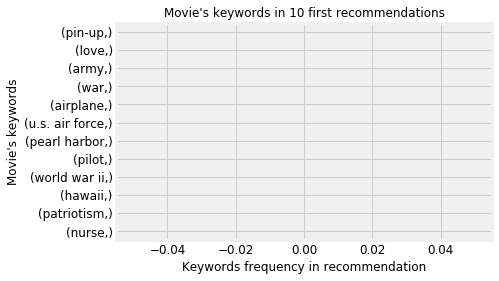

In [322]:
recom_kw_study(movie_ref, recom_nn_df)

### 6.2) Word embedding

Genres accuracy : 0.91


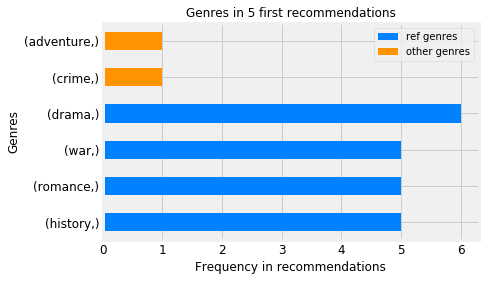

In [323]:
recom_genres_study(movie_ref, recom_emb_df)

Keywords accuracy : 0.03


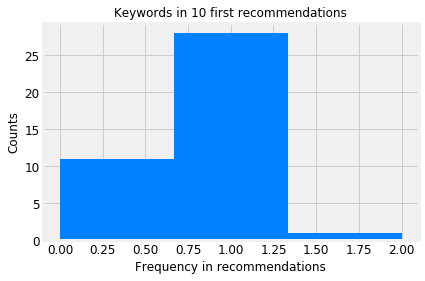

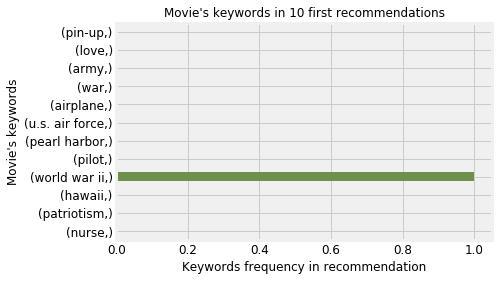

In [324]:
recom_kw_study(movie_ref, recom_emb_df)

In [344]:
movie_id = 44380
# Get layer
layer = emb_model.get_layer('movie_embedding')
# Extract weights
recommendation, movies_weights = extract_embedding(layer, movie_id)
# Get recommendations (closest movies)
recom_df = genres_kw_df.loc[recommendation[1:], ['title', 'genres', 'keywords']]
# Display reference
display(genres_kw_df.loc[movie_id, ['title', 'genres', 'keywords']].to_frame())
# Display recommendation
display(recom_df)
# Get recommendations genres
genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
# Count genres of selected movie
n_genres = len(genres_kw_df.loc[movie_id, :].genres_list)
# Process recommendation genres
genres_recommendation = recom_genres(genres_kw_df.loc[movie_id, :].genres, recom_df)
# Compute genres accuracy for recommendations
genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
print('Genres accuracy : {:.2f}'.format(genres_accuracy))
# Count kw of selected movie
n_kw = len(genres_kw_df.loc[movie_id, :].kw_list)
# Process recommendation keywords
keywords_recommendation = recom_kw(genres_kw_df.loc[movie_id, :].keywords, recom_df)
# Compute kw accuracy for recommendations
kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
print('Keywords accuracy : {:.2f}'.format(kw_accuracy))

,44380
title,Elysium
genres,"scifi,action,drama,thriller"
keywords,"dystopia,space station,class conflict"


,title,genres,keywords
37229,The Apocalypse,"drama,action,thriller,scifi",nan
5119,Volcano,"scifi,action,drama,thriller","subway,lava,volcano,volcanologist,los angeles"
35541,NYC: Tornado Terror,"drama,action,scifi,thriller",twister
5923,The Omega Man,"action,scifi,thriller,drama","post-apocalyptic,dystopia,survivalist,dystopia..."
5106,Until the End of the World,"thriller,drama,scifi,action","satellite,road movie"
3361,Outbreak,"action,drama,scifi,thriller","river,general,research,army,serum,monkey,epide..."
12563,Alive 2007,"drama,action,thriller,scifi",nan
4537,Children of Men,"drama,action,thriller,scifi","police state,hippie,rebel,miracle,future,dysto..."
6598,Chain Reaction,"action,drama,scifi,thriller","chicago,fbi,hydrogen bomb,secret lab,energy su..."
5204,No Escape,"action,drama,scifi,thriller","prison,prisoner,island,future,chase,dystopia,p..."


Genres accuracy : 1.00
Keywords accuracy : 0.05


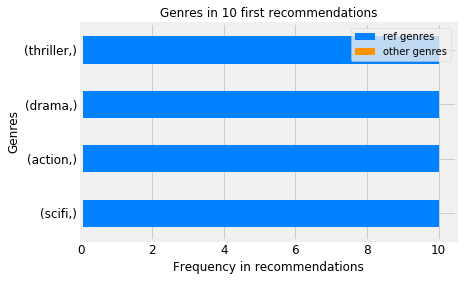

In [345]:
# Process recommendation genres
genres_recommendation = recom_genres(genres_kw_df.loc[movie_id, :].genres, recom_df)
# Define vector for colors
my_data = [myblue]*n_genres + (genres_recommendation.shape[0] - n_genres)*[myorange]
# Plot bar plot
genres_recommendation.plot.barh(color=my_cmap(my_norm(my_data)), fontsize=12)
# Get axes for graph tuning
ax = plt.gca()
# Set legend elements
legend_elements = [Patch(facecolor=my_cmap(my_norm([3]))[0], label='ref genres'),
                   Patch(facecolor=my_cmap(my_norm([9]))[0], label='other genres')]
# Create handmade legend
ax.legend(handles=legend_elements)
# Set axis labels and title
ax.set_xlabel("Frequency in recommendations", fontsize=12)
ax.set_ylabel("Genres", fontsize=12)
ax.set_title("Genres in 10 first recommendations", fontsize=12);

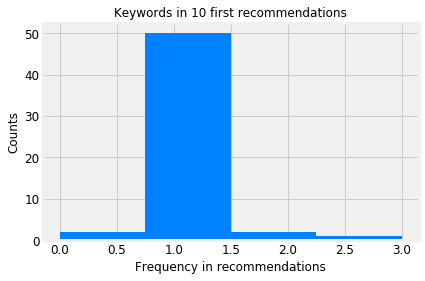

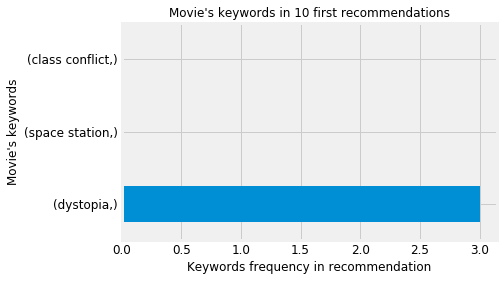

In [346]:
# Process recomendation keywords
keywords_recommendation = recom_kw(genres_kw_df.loc[movie_id, :].keywords, recom_df)
# Define vector for colors
my_data = [myblue]*n_kw + (keywords_recommendation.shape[0] - n_kw)*[myorange]

# Plot
# First plot : movie's keywords histogram
fig, ax = plt.subplots()
ax = keywords_recommendation.plot.hist(color=my_cmap(my_norm(my_data)), fontsize=12, bins=len(keywords_recommendation.unique()))
# Set axis labels and title
ax.set_xlabel("Frequency in recommendations", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)
ax.set_title("Keywords in 10 first recommendations", fontsize=12)
# pyplot.locator_params(axis='x', nbins=3)

# Second plot : movie's keywords frequency
fig, ax = plt.subplots()
# Movie's keywords for barplot
movie_kw = keywords_recommendation.loc[genres_kw_df.loc[movie_id, :].kw_list]
ax = movie_kw.plot.barh(fontsize=12)
# Set axis labels and title
ax.set_xlabel("Keywords frequency in recommendation", fontsize=12)
ax.set_ylabel("Movie's keywords", fontsize=12)
ax.set_title("Movie's keywords in 10 first recommendations", fontsize=12);